<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html Project2.do.txt  -->
<!-- dom:TITLE: Project 2 on Machine Learning, deadline November 4 (Midnight) -->

# Project 2 on Machine Learning, deadline November 4 (Midnight)
**[Data Analysis and Machine Learning FYS-STK3155/FYS4155](http://www.uio.no/studier/emner/matnat/fys/FYS3155/index-eng.html)**, Department of Physics, University of Oslo, Norway

Date: **Oct 8, 2024**

Copyright 1999-2024, [Data Analysis and Machine Learning FYS-STK3155/FYS4155](http://www.uio.no/studier/emner/matnat/fys/FYS3155/index-eng.html). Released under CC Attribution-NonCommercial 4.0 license

### Part a): Write your own Stochastic Gradient Descent  code, first step

In order to get started, we will now replace in our standard ordinary
least squares (OLS) and Ridge regression codes (from project 1) the
matrix inversion algorithm with our own gradient descent (GD) and SGD
codes.  You can use the Franke function or the terrain data from
project 1. **However, we recommend using a simpler function like**
$f(x)=a_0+a_1x+a_2x^2$ or higher-order one-dimensional polynomials.
You can obviously test your final codes against for example the Franke
function.

The exercise set for week 41 should help in solving this part of the project.

You should include in your analysis of the GD and SGD codes the following elements
1. A plain gradient descent with a fixed learning rate (you will need to tune it) using the analytical expression for the gradient.

2. Add momentum to the plain GD code and compare convergence with a fixed learning rate (you may need to tune the learning rate). Keep using the analytical expression for the gradient.

3. Repeat these steps for stochastic gradient descent with mini batches and a given number of epochs. Use a tunable learning rate as discussed in the lectures from weeks 39 and 40. Discuss the results as functions of the various parameters (size of batches, number of epochs etc). Use the analytical gradient.

4. Implement the Adagrad method in order to tune the learning rate. Do this with and without momentum for plain gradient descent and SGD.

5. Add RMSprop and Adam to your library of methods for tuning the learning rate.

The lecture notes from [weeks 39 and 40 contain more
details](https://compphysics.github.io/MachineLearning/doc/pub/week39/html/week39.html) and code examples. Feel free to use these examples.
1. Replace thereafter your analytical gradient with either **Autograd** or **JAX**

**Feel free to use codes on these methods from the lecture notes from week 39 and week 40**.

In summary, you should 
perform an analysis of the results for OLS and Ridge regression as
function of the chosen learning rates, the number of mini-batches and
epochs as well as algorithm for scaling the learning rate. You can
also compare your own results with those that can be obtained using
for example **Scikit-Learn**'s various SGD options.  Discuss your
results. For Ridge regression you need now to study the results as functions of  the hyper-parameter $\lambda$ and 
the learning rate $\eta$.  Discuss your results.

You will need your SGD code for the setup of the Neural Network and
Logistic Regression codes. You will find the Python [Seaborn
package](https://seaborn.pydata.org/generated/seaborn.heatmap.html)
useful when plotting the results as function of the learning rate
$\eta$ and the hyper-parameter $\lambda$ when you use Ridge
regression. Since you will use different gradient descent methods, you can also add Lasse regression. This is however optional. How to code Lasso regression is discussed in the lecture notes from week 40.

We recommend reading chapter 8 on optimization from the textbook of Goodfellow, Bengio and Courville at <https://www.deeplearningbook.org/>. This chapter contains many useful insights and discussions on the optimization part of machine learning.

In [85]:
from random import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import time
import random
import seaborn as sb
from pathlib import Path

from functions import*

# 1. A plain gradient descent with a fixed learning rate (you will need to tune it) using the analytical expression for the gradient.

# OLS:

In [86]:
# Global parameters
N = 128  # no. data points
N_iters = 1000  # max no. iterations before stopping
noise_std = 0.1  # standard deviation of noise
beta_tol = 1e-8  # beta tolerance for stopping iteration when |beta_new - beta_old| <= beta_tol
rng_seed = 2023
HEATMAP_CMAP = "coolwarm"  # colormap for seaborn heatmap plots

# Create data set
rng = np.random.default_rng(rng_seed)
x = rng.random((N, 1))
noise = rng.normal(0, noise_std, x.shape)
y = 4 + 3*x + 2*x**2 + noise
#y = 5 - 10 * x + 2 * x**2 + noise

# Analytical calculations for comparing
X = np.c_[np.ones((N, 1)), x]  # ??

beta_ols = np.linalg.inv(X.T @ X) @ (X.T @ y)  # own OLS inversion

# Hessian matrices 
H_ols = 2 / N * X.T @ X
eig_ols, iter = np.linalg.eig(H_ols)
print(f"OLS: 1/lambda_max={1 / max(eig_ols):.3f}")

OLS: 1/lambda_max=0.390


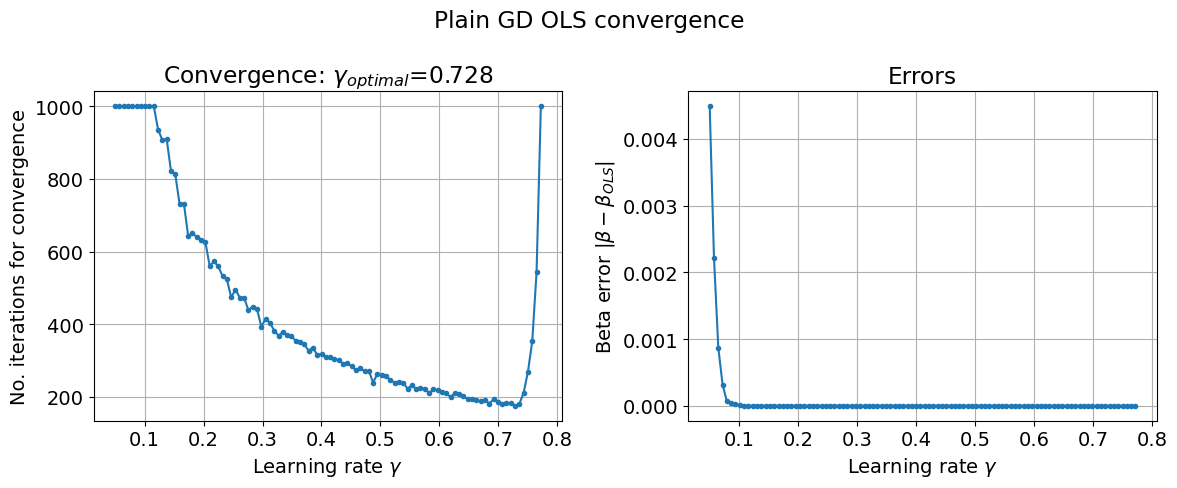

In [87]:
# Parameters
learn_rates = np.linspace(0.05, 2 / np.max(eig_ols), 100, endpoint=False)

no_iters = np.empty(learn_rates.size)  # store the number of iterations needed to converge
errors = np.empty_like(no_iters)  # store the beta errors

error_best = 1e10
beta_best = 0
for i, learn_rate in enumerate(learn_rates):
    # Iterate through and improve beta
    beta = rng.standard_normal((2, 1))  # create 2 random beta parameters [b_0, b_1] to test convergence with
    beta_prev = 0
    iter = 0
    while iter < N_iters and any(abs(beta - beta_prev) > beta_tol):  # convergence test
        beta_prev = beta.copy()

        # Update beta
        grad = 2 / N * X.T @ (X @ beta - y)
        beta -= learn_rate * grad

        iter += 1
    no_iters[i] = iter

    error = np.max(abs(beta - beta_ols))
    if error < error_best:
        error_best = error
        beta_best = beta
    errors[i] = error






# Figure output directory
RESULTS_DIR = Path("results").resolve()
FIGURES_DIR = RESULTS_DIR / "figures"

# Create them if they dont exist
if not RESULTS_DIR.exists():
    RESULTS_DIR.mkdir()

if not FIGURES_DIR.exists():
    FIGURES_DIR.mkdir()



fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Plain GD OLS convergence")
fig.suptitle(f"Plain GD OLS convergence")

# Plot convergence
axs[0].plot(learn_rates, no_iters, ".-")
axs[0].set_title("Convergence: $\gamma_{optimal}$=" + f"{learn_rates[np.argmin(no_iters)]:.3f}")
axs[0].set_xlabel("Learning rate $\gamma$")
axs[0].set_ylabel("No. iterations for convergence")
axs[0].grid(True)

# Plot error
axs[1].plot(learn_rates, errors, ".-")
axs[1].set_title("Errors")
axs[1].set_xlabel("Learning rate $\gamma$")
axs[1].set_ylabel(r"Beta error $|\beta - \beta_{OLS}|$")
axs[1].grid(True)
plt.savefig(FIGURES_DIR / "Plain_GD_OLS.png")

plt.tight_layout()

In [17]:
print(f"Beta OLS={beta_ols.ravel()}")
print(f"Best beta={beta_best.ravel()}")
print(f"Fastest convergence={np.min(no_iters)}")

Beta OLS=[3.63898721 5.06975183]
Best beta=[3.63898722 5.06975183]
Fastest convergence=175.0


**Ridge :**

lmbda=1e-05, beta_ridge=[3.63898852 5.06974873], beta=[3.63915482 5.06935586], max error=0.005010446277883496
lmbda=0.0001, beta_ridge=[3.63900031 5.06972089], beta=[3.64066059 5.06579768], max error=0.006692715654287085
lmbda=0.001, beta_ridge=[3.63911818 5.06944248], beta=[3.65543402 5.03073947], max error=0.042292757008114634
lmbda=0.01, beta_ridge=[3.64029512 5.06666165], beta=[3.77866129 4.72535488], max error=0.3407635134008906
lmbda=0.1, beta_ridge=[3.65189027 5.03917406], beta=[4.07783639 3.4266966 ], max error=1.6124780499981743
lmbda=1, beta_ridge=[3.75235725 4.79284328], beta=[2.69685961 1.66435394], max error=3.1284893921859425
lmbda=10, beta_ridge=[4.07379711 3.60826319], beta=[0.55286839 0.32316182], max error=3.520640158673806
Min no. iterations=10.0
Fastest convergence combination (gamma, lambda)=(0.050, 10.000) with error=3.521


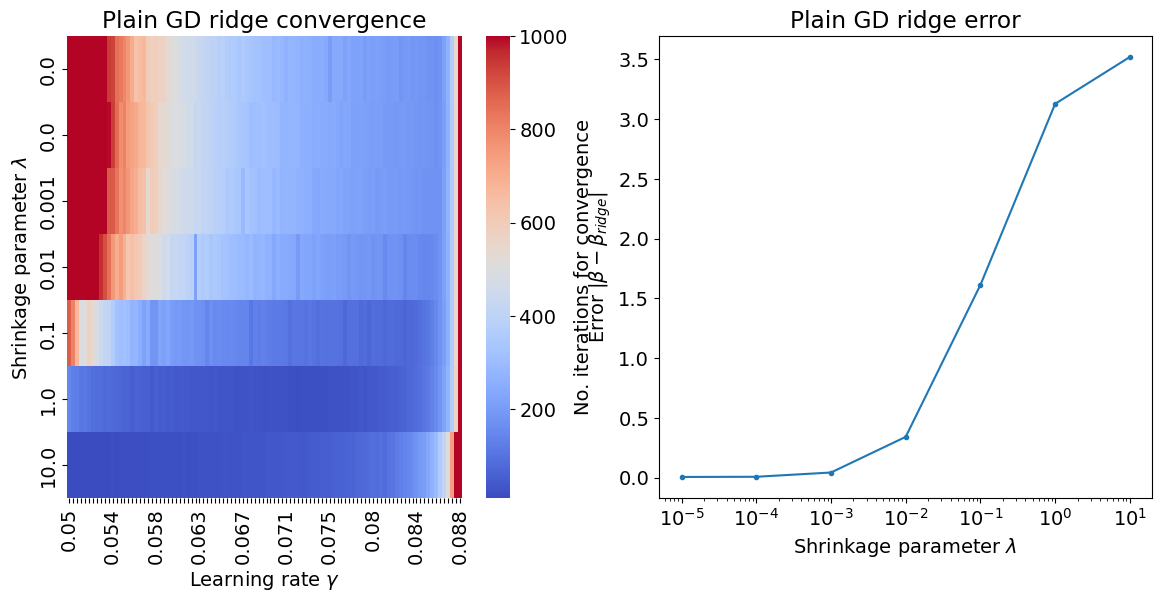

In [23]:
# Parameters
ridge_lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]  # lambda vals to plot

no_iters = np.empty((learn_rates.size, len(ridge_lambdas)))  # store the number of iterations needed to converge
errors = np.empty_like(no_iters)  # store the beta errors

# Iterate through each lambda and each learning rate and test convergence
for j, lmbda in enumerate(ridge_lambdas):
    # Calculate max eigenvalue
    XT_X = X.T @ X
    I = np.identity(np.shape(XT_X)[0])
    lmbda_I = lmbda * I

    beta_ridge = np.linalg.inv(XT_X + lmbda_I) @ (X.T @ y)  # own Ridge inversion
    H = 2 / N * XT_X + 2 * lmbda_I  # Hessian matrix
    eig_ridge, iter = np.linalg.eig(H)

    # Create learning rate values to test 
    learn_rates = np.linspace(0.05, 2 / np.max(eig_ridge), 100, endpoint=False)
    for i, learn_rate in enumerate(learn_rates):
        # Iterate through and improve beta
        beta = rng.standard_normal((2, 1))  # create 2 random beta parameters [b_0, b_1] to test convergence with
        beta_prev = 0
        iter = 0
        while iter < N_iters and any(abs(beta - beta_prev) > beta_tol):  # convergence test
            beta_prev = beta.copy()

            # Update beta
            grad = 2 / N * X.T @ (X @ beta - y) + 2 * lmbda * beta
            beta -= learn_rate * grad

            # stop if beta is blowing up -> will overflow
            if any(beta > 1e8):
                iter = 1000
                break

            iter += 1
        no_iters[i, j] = iter
        errors[i, j] = np.max(abs(beta - beta_ridge))
    print(f"{lmbda=}, beta_ridge={beta_ridge.ravel()}, beta={beta.ravel()}, max error={errors[0, j]}")

# Heatmap plotting
plt.figure(figsize=(14, 6))

###### Convergence heatmap
# Set xlabel ticks to show a total of 10 values, with 3 decimal places
xticks = np.round(learn_rates, 3)
keptticks = xticks[::int(len(learn_rates) / 10) + 1]
xticks = ['' for _ in xticks]
xticks[::int(len(xticks) / 10) + 1] = keptticks

plt.subplot(1, 2, 1)
ax = sb.heatmap(
        no_iters.T,
        annot=False,
        cmap=HEATMAP_CMAP,
        xticklabels=xticks,
        yticklabels=np.round(ridge_lambdas, 3),
        cbar_kws={"label": "No. iterations for convergence"}  # colorbar label
)
plt.xticks(rotation=90)  # sideways xticks
plt.title("Plain GD ridge convergence")
plt.xlabel("Learning rate $\gamma$")
plt.ylabel("Shrinkage parameter $\lambda$")
######


###### Error plot
plt.subplot(1, 2, 2)
plt.plot(ridge_lambdas, errors[0, :], ".-")  # the errors are almost the same for each learning rate value
plt.title("Plain GD ridge error")
plt.ylabel(r"Error $|\beta-\beta_{ridge}|$")
plt.xlabel("Shrinkage parameter $\lambda$")
plt.xscale("log")
###### 
plt.savefig(FIGURES_DIR / "Plain_GD_ridge.png")

#plt.tight_layout()


print(f"Min no. iterations={np.min(no_iters)}")
optimal_indices = np.unravel_index(np.argmin(no_iters), no_iters.shape)
print(
        f"Fastest convergence combination (gamma, lambda)=({learn_rates[optimal_indices[0]]:.3f}, {ridge_lambdas[optimal_indices[1]]:.3f}) with error={errors[optimal_indices[0], optimal_indices[1]]:.3f}"
)

Lambda=1e-05, Ridge Solution=[3.63898852 5.06974873], Final Beta=[3.63915436 5.06935561], Max Error=0.0037285170217176145
Lambda=0.0001, Ridge Solution=[3.63900031 5.06972089], Final Beta=[3.64066113 5.06579797], Max Error=0.008109278227848904
Lambda=0.001, Ridge Solution=[3.63911818 5.06944248], Final Beta=[3.65543356 5.03073921], Max Error=0.04165205276836126
Lambda=0.01, Ridge Solution=[3.64029512 5.06666165], Final Beta=[3.7786618  4.72535517], Max Error=0.34356278376633576
Lambda=0.1, Ridge Solution=[3.65189027 5.03917406], Final Beta=[4.07783594 3.42669634], Max Error=1.6125377390884372
Lambda=1, Ridge Solution=[3.75235725 4.79284328], Final Beta=[2.69686014 1.66435424], Max Error=3.1284968356707665
Lambda=10, Ridge Solution=[4.07379711 3.60826319], Final Beta=[0.55301394 0.32324185], Max Error=3.520640245094867
Minimum iterations needed: 7.0
Optimal (Learning Rate, Lambda)=(0.050, 10.000) with Error=3.521


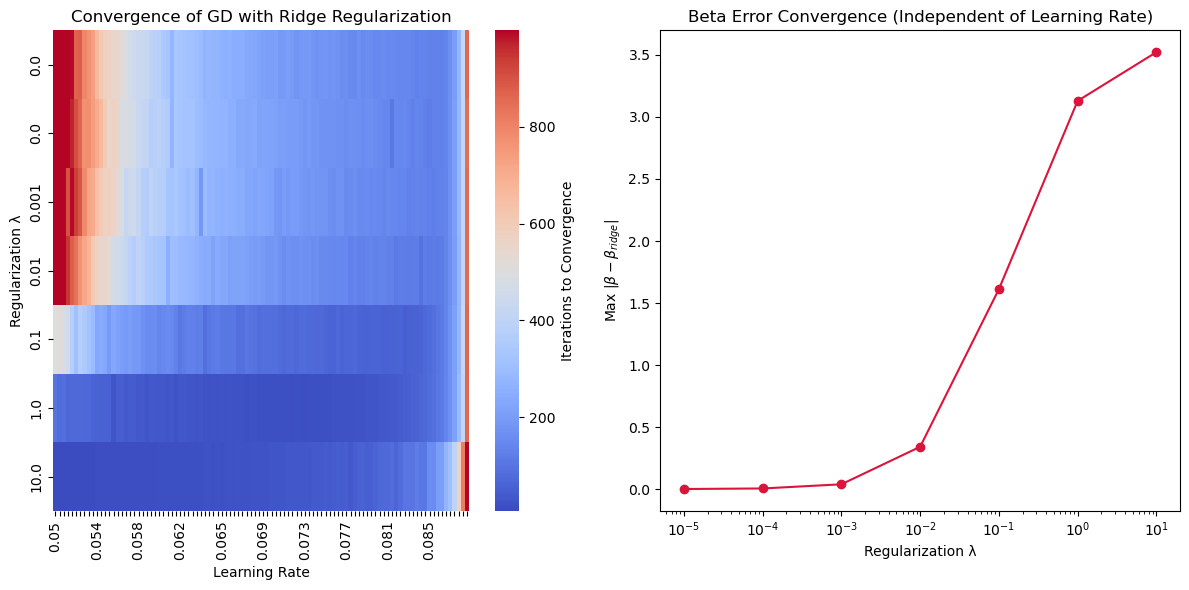

In [15]:
# Parameters
lambda_values = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10]  # Ridge regularization values
iteration_counts = np.empty((len(lambda_values), 100))  # Matrix to store iterations to converge
beta_errors = np.empty_like(iteration_counts)  # Matrix to store beta errors

# Main loop through ridge parameters and learning rates
for idx_lambda, lam in enumerate(lambda_values):
    # Compute ridge solution
    XtX = X.T @ X
    identity_matrix = np.eye(XtX.shape[0])
    ridge_term = lam * identity_matrix
    ridge_solution = np.linalg.inv(XtX + ridge_term) @ (X.T @ y)  # Direct ridge solution

    # Calculate Hessian and its eigenvalues for convergence analysis
    hessian = (2 / len(X)) * XtX + 2 * ridge_term
    eigenvalues, _ = np.linalg.eig(hessian)

    # Generate learning rate range based on the largest eigenvalue
    learning_rates = np.linspace(0.05, 2 / np.max(eigenvalues), 100, endpoint=False)
    for idx_lr, lr in enumerate(learning_rates):
        beta_guess = np.random.standard_normal((2, 1))  # Start with random beta estimates
        previous_beta = np.zeros_like(beta_guess)
        max_iterations = 1000  # Set a max limit to avoid infinite loops
        tolerance = 1e-6

        # Iterative gradient descent loop for convergence testing
        for iters in range(max_iterations):
            # Check convergence
            if np.all(np.abs(beta_guess - previous_beta) <= tolerance):
                break

            previous_beta = beta_guess.copy()
            gradient = (2 / len(X)) * X.T @ (X @ beta_guess - y) + 2 * lam * beta_guess
            beta_guess -= lr * gradient

            # Break if divergence occurs
            if np.any(beta_guess > 1e8):
                iters = max_iterations
                break

        # Store results
        iteration_counts[idx_lambda, idx_lr] = iters
        beta_errors[idx_lambda, idx_lr] = np.max(np.abs(beta_guess - ridge_solution))
    print(f"Lambda={lam}, Ridge Solution={ridge_solution.ravel()}, Final Beta={beta_guess.ravel()}, Max Error={beta_errors[idx_lambda, 0]}")

# Plot convergence heatmap
plt.figure(figsize=(12, 6))

# Plot 1: Convergence Heatmap
plt.subplot(1, 2, 1)
xticks = np.round(learning_rates, 3)
display_ticks = xticks[::len(xticks) // 10]
xticks_labels = [''] * len(xticks)
xticks_labels[::len(xticks) // 10] = display_ticks

sns.heatmap(
    iteration_counts,
    annot=False,
    cmap=HEATMAP_CMAP,
    xticklabels=xticks_labels,
    yticklabels=np.round(lambda_values, 3),
    cbar_kws={"label": "Iterations to Convergence"}
)
plt.xticks(rotation=90)
plt.title("Convergence of GD with Ridge Regularization")
plt.xlabel("Learning Rate")
plt.ylabel("Regularization λ")

# Plot 2: Beta Error vs Lambda
plt.subplot(1, 2, 2)
plt.plot(lambda_values, beta_errors[:, 0], "o-", color='crimson')
plt.xscale("log")
plt.title("Beta Error Convergence (Independent of Learning Rate)")
plt.xlabel("Regularization λ")
plt.ylabel(r"Max |$\beta - \beta_{ridge}$|")

plt.tight_layout()

# Report results
min_iters = np.min(iteration_counts)
best_idx = np.unravel_index(np.argmin(iteration_counts), iteration_counts.shape)
best_learning_rate = learning_rates[best_idx[1]]
best_lambda = lambda_values[best_idx[0]]
print(f"Minimum iterations needed: {min_iters}")
print(f"Optimal (Learning Rate, Lambda)=({best_learning_rate:.3f}, {best_lambda:.3f}) with Error={beta_errors[best_idx[0], best_idx[1]]:.3f}")


# 2. Gradient descent with momentum/memory (GDM) as function of fixed learning rate

C:\Users\user\AppData\Local\Temp\ipykernel_1552\2436404519.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  errors[i] = error


Beta OLS=[3.63898721 5.06975183]
Best beta=[3.63898722 5.06975183]
Fastest convergence=49.0


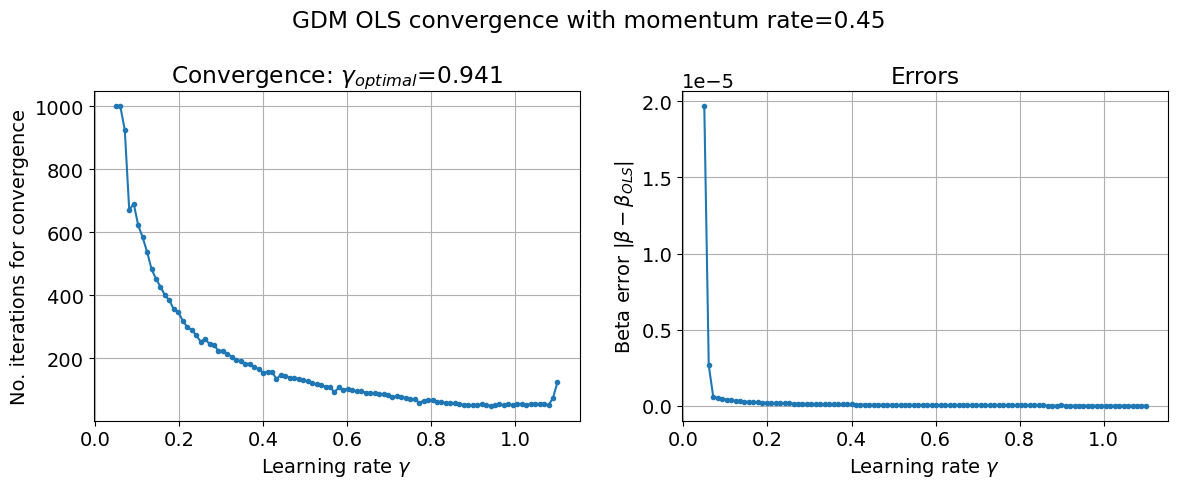

In [29]:
# Parameters
learning_rates = np.linspace(0.05, 1.1, 100)
momentum_rate = 0.45  # memory rate

no_iterations = np.empty(learning_rates.size)  # store the number of iterations needed to converge
errors = np.empty_like(no_iterations)  # store the beta errors

error_best = 1e10
beta_best = 0
for i, learn_rate in enumerate(learning_rates):
    # Iterate through and improve beta
    beta = rng.standard_normal((2, 1))  # create 2 random beta parameters [b_0, b_1] to test convergence with
    beta_prev = 0
    change = 0
    iter = 0
    while iter < N_iters and any(abs(beta - beta_prev) > beta_tol):  # convergence test
        beta_prev = beta.copy()

        # Calculate new change
        grad = 2 / N * X.T @ (X @ beta - y)
        new_change = learn_rate * grad + momentum_rate * change

        # Update values
        beta -= new_change
        change = new_change.copy()
        iter += 1
    no_iterations[i] = iter

    error = max(abs(beta - beta_ols))
    if error < error_best:
        error_best = error
        beta_best = beta
    errors[i] = error

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle(f"GDM OLS convergence with momentum rate={momentum_rate}")

# Plot convergence
axs[0].plot(learning_rates, no_iters, ".-")
axs[0].set_title("Convergence: $\gamma_{optimal}$=" + f"{learning_rates[np.argmin(no_iterations)]:.3f}")
axs[0].set_xlabel("Learning rate $\gamma$")
axs[0].set_ylabel("No. iterations for convergence")
axs[0].grid(True)

# Plot error
axs[1].plot(learning_rates, errors, ".-")
axs[1].set_title("Errors")
axs[1].set_xlabel("Learning rate $\gamma$")
axs[1].set_ylabel(r"Beta error $|\beta - \beta_{OLS}|$")
axs[1].grid(True)

plt.savefig(FIGURES_DIR / "GD_OLS_with_momentum.png")
plt.tight_layout()

print(f"Beta OLS={beta_ols.ravel()}")
print(f"Best beta={beta_best.ravel()}")
print(f"Fastest convergence={np.min(no_iters)}")

### Ridge:

lmbda=0.0001, beta_ridge=[3.63900031 5.06972089], beta=[3.64066065 5.06579767], max error=0.003943465927378931
lmbda=0.001, beta_ridge=[3.63911818 5.06944248], beta=[3.65543406 5.03073945], max error=0.03871767943518467
lmbda=0.01, beta_ridge=[3.64029512 5.06666165], beta=[3.77866131 4.72535491], max error=0.34131031663166755
lmbda=0.1, beta_ridge=[3.65189027 5.03917406], beta=[4.07783642 3.42669661], max error=1.6124777623151996
lmbda=1, beta_ridge=[3.75235725 4.79284328], beta=[2.69685967 1.66435398], max error=3.1284892939113385
lmbda=10, beta_ridge=[4.07379711 3.60826319], beta=[0.55315696 0.32332049], max error=3.5206401750462595
Min no. iterations=41.0
Fastest convergence combination (gamma, lambda)=(0.059, 1.000) with error=3.128


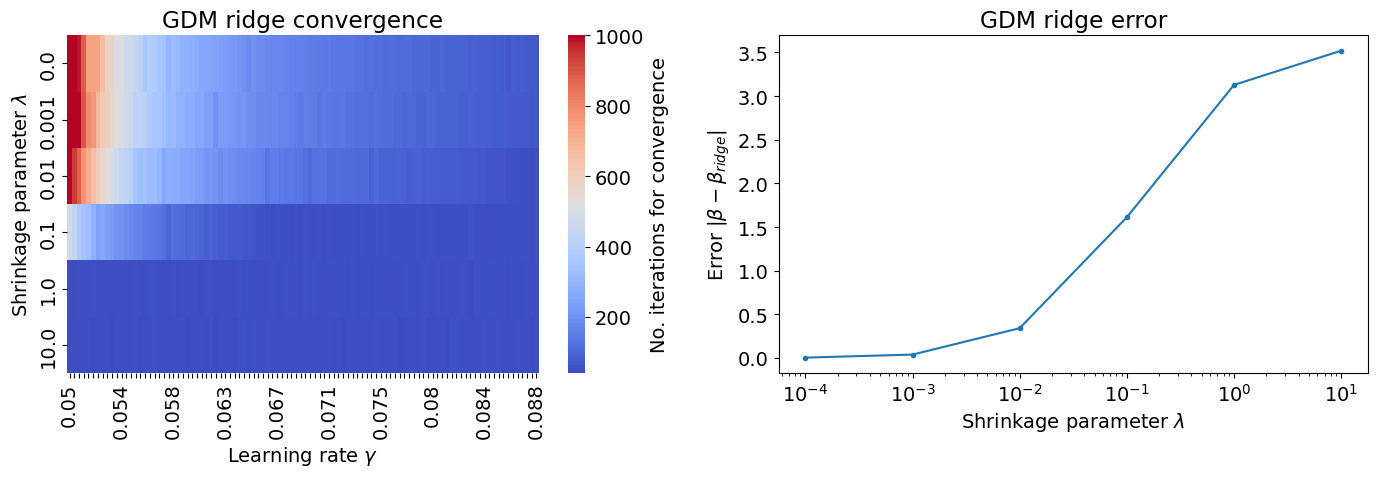

In [31]:
# Parameters
ridge_lambdas = [0.0001, 0.001, 0.01, 0.1, 1, 10]  # lambda vals to plot

no_iters = np.empty((learn_rates.size, len(ridge_lambdas)))  # store the number of iterations needed to converge
errors = np.empty_like(no_iters)  # store the beta errors

# Iterate through each lambda and each learning rate and test convergence
for j, lmbda in enumerate(ridge_lambdas):
    # Calculate max eigenvalue
    XT_X = X.T @ X
    I = np.identity(np.shape(XT_X)[0])
    lmbda_I = lmbda * I

    beta_ridge = np.linalg.inv(XT_X + lmbda_I) @ (X.T @ y)  # own Ridge inversion
    H = 2 / N * XT_X + 2 * lmbda_I  # Hessian matrix
    eig_ridge, iter = np.linalg.eig(H)

    # Create learning rate values to test 
    learn_rates = np.linspace(0.05, 2 / np.max(eig_ridge), 100, endpoint=False)
    for i, learn_rate in enumerate(learn_rates):
        # Iterate through and improve beta
        beta = rng.standard_normal((2, 1))  # create 2 random beta parameters [b_0, b_1] to test convergence with
        beta_prev = 0
        change = 0
        iter = 0
        while iter < N_iters and any(abs(beta - beta_prev) > beta_tol):  # convergence test
            beta_prev = beta.copy()

            # Calculate new change
            grad = 2 / N * X.T @ (X @ beta - y) + 2 * lmbda * beta
            new_change = learn_rate * grad + momentum_rate * change

            # Update values
            beta -= new_change
            change = new_change.copy()
            iter += 1

            # stop if beta is blowing up -> will overflow
            if any(beta > 1e8):
                iter = 1000
                break

        no_iters[i, j] = iter
        errors[i, j] = np.max(abs(beta - beta_ridge))
    print(f"{lmbda=}, beta_ridge={beta_ridge.ravel()}, beta={beta.ravel()}, max error={errors[0, j]}")

# Heatmap plotting
plt.figure(figsize=(14, 5))

###### Convergence heatmap
# Set xlabel ticks to show a total of 10 values, with 3 decimal places
xticks = np.round(learn_rates, 3)
keptticks = xticks[::int(len(learn_rates) / 10) + 1]
xticks = ['' for _ in xticks]
xticks[::int(len(xticks) / 10) + 1] = keptticks

plt.subplot(1, 2, 1)
ax = sb.heatmap(
        no_iters.T,
        annot=False,
        cmap=HEATMAP_CMAP,
        xticklabels=xticks,
        yticklabels=np.round(ridge_lambdas, 3),
        cbar_kws={"label": "No. iterations for convergence"},  # colorbar label
)
plt.xticks(rotation=90)  # sideways xticks
plt.title("GDM ridge convergence")
plt.xlabel("Learning rate $\gamma$")
plt.ylabel("Shrinkage parameter $\lambda$")
######


###### Error plot
plt.subplot(1, 2, 2)
plt.plot(ridge_lambdas, errors[0, :], ".-")  # the errors are the same for each learning rate value
plt.title("GDM ridge error")
plt.ylabel(r"Error $|\beta-\beta_{ridge}|$")
plt.xlabel("Shrinkage parameter $\lambda$")
plt.xscale("log")
###### 
plt.savefig(FIGURES_DIR / "GD_Ridge_with_momentum.png")
plt.tight_layout()

print(f"Min no. iterations={np.min(no_iters)}")
optimal_indices = np.unravel_index(np.argmin(no_iters), no_iters.shape)
print(
        f"Fastest convergence combination (gamma, lambda)=({learn_rates[optimal_indices[0]]:.3f}, {ridge_lambdas[optimal_indices[1]]:.3f}) with error={errors[optimal_indices[0], optimal_indices[1]]:.3f}")

## 3.Stochastic gradient descent with mini batches and a given number of epochs

In [35]:
# SDG parameters
M_vals = np.asarray([1, 2, 4, 8, 16, 32, 64, 128])  # size of each minibatch
N_epoch_vals = [1, 10, 100, 1000]  # number of iterations over all the minibatches 

m_vals = (N / M_vals).astype(int)  # number of minibatches


def learning_schedule(t):
    """Function for a scaling learning rate, it reduces over time/iterations."""
    t0 = 5
    t1 = 50
    return t0 / (t + t1)

### OLS:

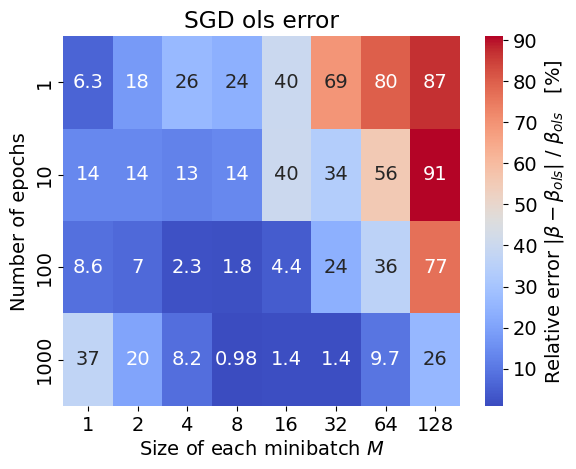

In [36]:
rel_errors = np.empty((M_vals.size, len(N_epoch_vals)))
for j, N_epoch in enumerate(N_epoch_vals):  # iterate through different epochs values
    # then iterate through different values of total number of batches m (and corresponding M)
    for i, m in enumerate(m_vals):
        M = M_vals[j]
        beta = rng.standard_normal((2, 1))  # create 2 random beta parameters [b_0, b_1]

        for epoch in range(N_epoch):  # then iterate through all different epoch values
            for k in range(m):  # now do the GD calculation for each of the minibatches
                # Pick a minibatch at random
                random_index = M * rng.integers(m)
                xk = X[random_index:random_index + M]
                yk = y[random_index:random_index + M]

                # Gradient descent on the random batch
                gradients = 2 / M * xk.T @ ((xk @ beta) - yk)
                learn_rate = learning_schedule(epoch * m + k)
                beta -= learn_rate * gradients
        rel_errors[i, j] = np.max(abs(beta - beta_ols) / beta_ols)

# Error heatmap
plt.figure()
plt.title("SGD ols error")
ax = sb.heatmap(
        rel_errors.T * 100,
        annot=True,
        cmap=HEATMAP_CMAP,
        xticklabels=M_vals,
        yticklabels=N_epoch_vals,
        cbar_kws={"label": r"Relative error $|\beta - \beta_{ols}|\ /\ \beta_{ols}$   [%]"}  # colorbar label
)
plt.ylabel("Number of epochs")
plt.xlabel("Size of each minibatch $M$");
plt.savefig(FIGURES_DIR / "SGD_minibatch_epoches_OLS.png")

### Ridge:

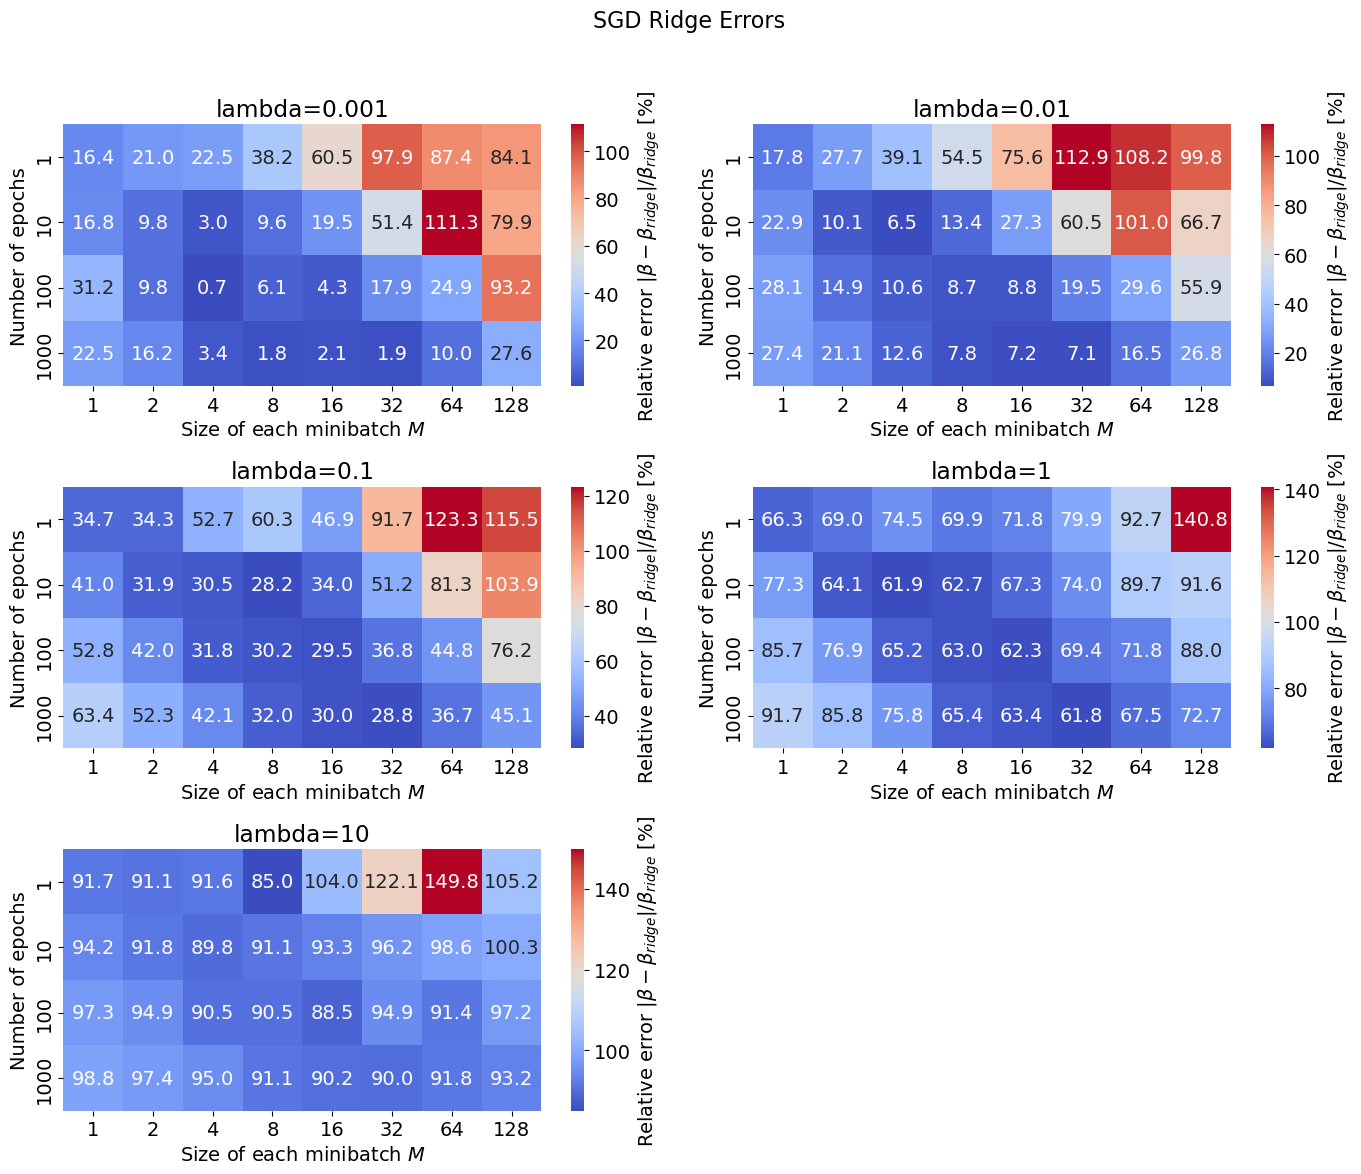

In [38]:
# Ridge parameter values
lmdbas = [0.001, 0.01, 0.1, 1, 10]

# Set the layout to 3 rows and 2 columns (total of 6 subplots, 5 will be used)
nrows, ncols = 3, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(14, 12))
fig.suptitle("SGD Ridge Errors", fontsize=16)

XT_X = X.T @ X

# Loop over each lambda value and create the heatmap plot
for l, lmbda in enumerate(lmdbas):
    # Ridge regression: calculate beta for the current lambda
    I = np.identity(np.shape(XT_X)[0])
    lmbda_I = lmbda * I
    beta_ridge = np.linalg.inv(XT_X + lmbda_I) @ (X.T @ y)
    
    rel_errors = np.empty((M_vals.size, len(N_epoch_vals)))
    
    # Iterate through different epoch and batch values
    for j, N_epoch in enumerate(N_epoch_vals):  
        for i, m in enumerate(m_vals):
            M = M_vals[j]
            beta = rng.standard_normal((2, 1))
    
            # Perform gradient descent for each minibatch
            for epoch in range(N_epoch):
                for k in range(m):
                    random_index = M * rng.integers(m)
                    xk = X[random_index:random_index + M]
                    yk = y[random_index:random_index + M]
                    
                    gradients = 2 / M * xk.T @ ((xk @ beta) - yk) + 2 * lmbda * beta
                    learn_rate = learning_schedule(epoch * m + k)
                    beta -= learn_rate * gradients
            
            # Calculate the relative error
            rel_errors[i, j] = np.max(abs(beta - beta_ridge) / beta_ridge)
    
    # Determine row and column positions based on `l`
    row = l // ncols
    col = l % ncols
    
    # Plot the heatmap for this lambda value
    im = sns.heatmap(
            rel_errors.T * 100,
            ax=axs[row, col],
            annot=True,
            fmt=".1f",
            cmap="coolwarm",  # Updated color map for better readability
            xticklabels=M_vals,
            yticklabels=N_epoch_vals,
            cbar_kws={"label": r"Relative error $|\beta - \beta_{ridge}| / \beta_{ridge}$ [%]"}
    )
    axs[row, col].set_title(f"lambda={lmbda}")
    axs[row, col].set_ylabel("Number of epochs")
    axs[row, col].set_xlabel("Size of each minibatch $M$")

# Hide the last unused subplot if it exists (bottom right)
if len(lmdbas) < nrows * ncols:
    for idx in range(len(lmdbas), nrows * ncols):
        fig.delaxes(axs.flatten()[idx])

# Adjust layout and display the plot
fig.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the title space
plt.savefig(FIGURES_DIR / "SGD_minibatch_epoches_Ridge.png")
plt.show()


IndexError: index 2 is out of bounds for axis 1 with size 2

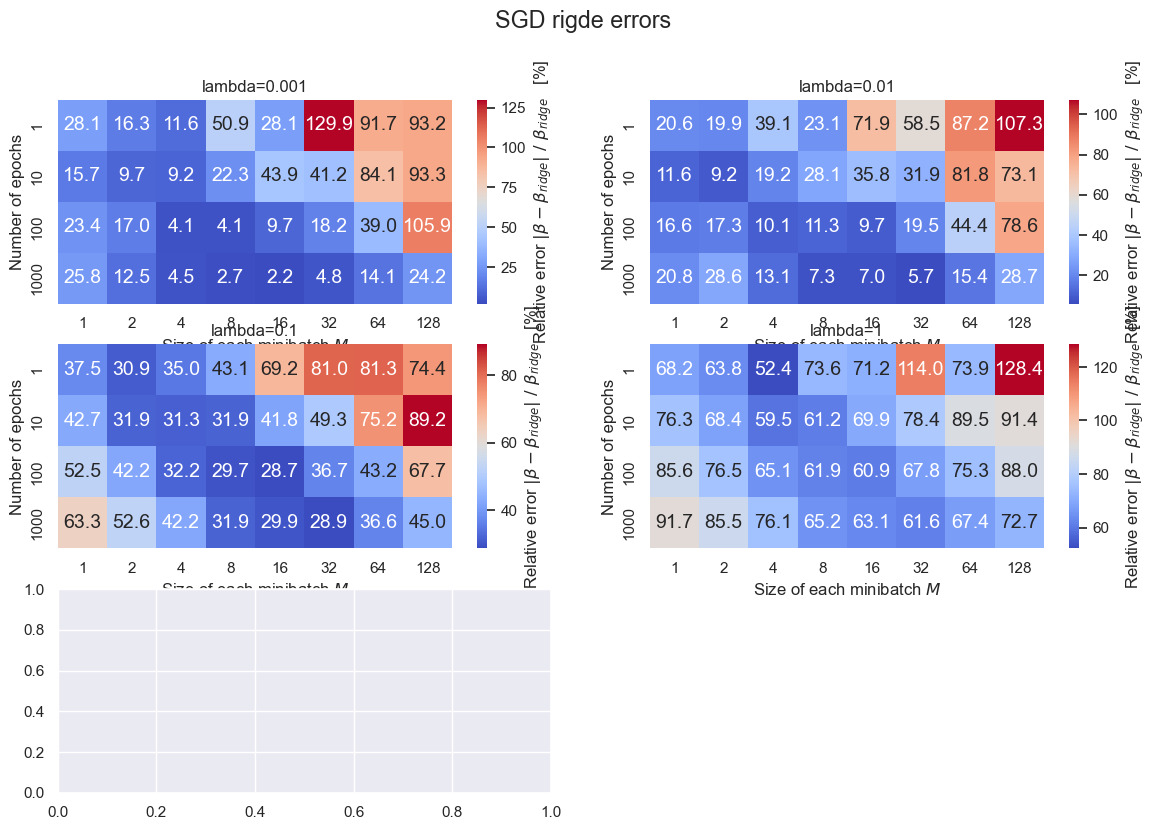

# 3. Stochastic gradient descent with momentum (SGDM) as function of batch size $M$ and number of epochs $N_\text{epochs}$, with replacement

### OLS:

In [41]:
# SDG parameters
M_vals = np.asarray([1, 2, 4, 8, 16, 32, 64, 128])  # size of each minibatch
N_epoch_vals = [1, 10, 100, 1000]  # number of iterations over all the minibatches 
momentum_rates = [0.1, 0.3, 0.4, 0.5, 0.75, 0.95]  # momentum rate

m_vals = (N / M_vals).astype(int)  # number of minibatches


def learning_schedule(t):
    """Function for a scaling learning rate, it reduces over time/iterations."""
    t0 = 5
    t1 = 50
    return t0 / (t + t1)

C:\Users\user\AppData\Local\Temp\ipykernel_1552\3535046356.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


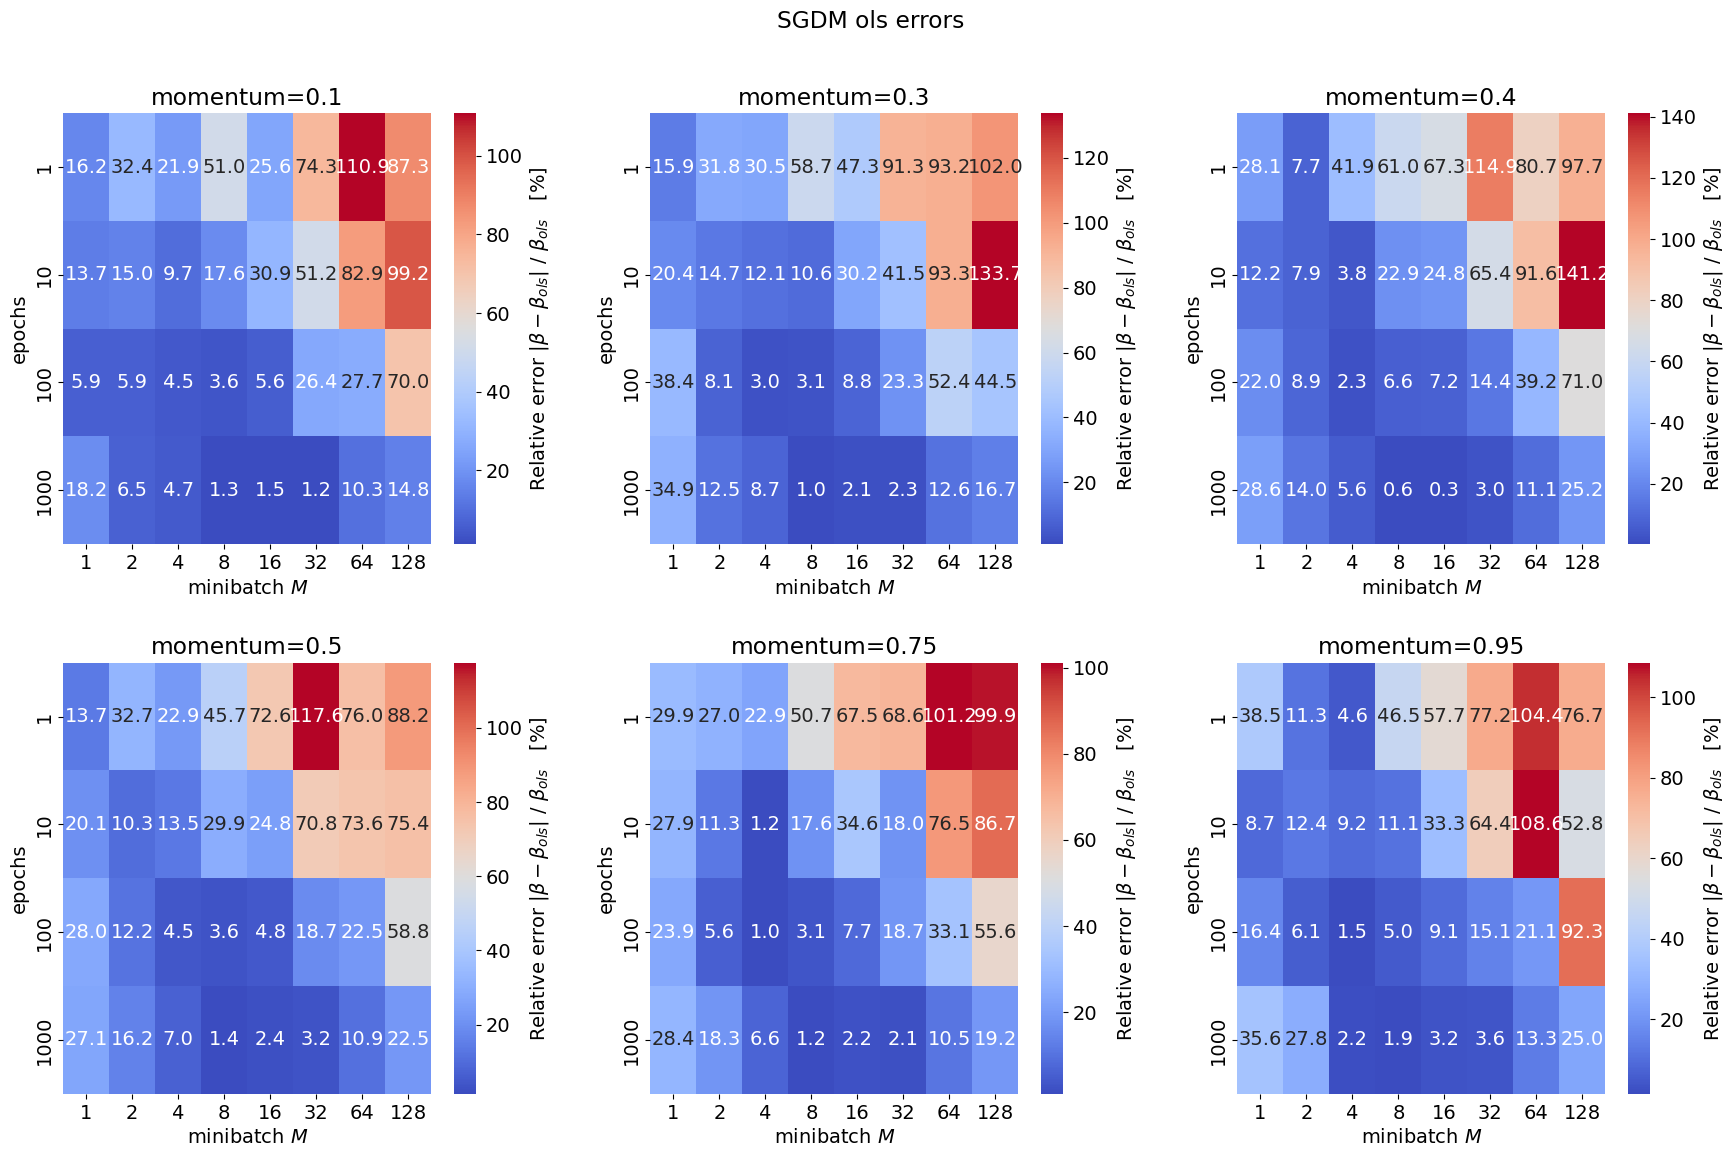

In [47]:
# Plot error heatmap for each different momentum rate value
nrows, ncols = 2, 3
fig, axs = plt.subplots(nrows, ncols, figsize=(18, 12))
fig.suptitle("SGDM ols errors")
#fig.suptitle("SGDM ols errors")

for l, momentum_rate in enumerate(momentum_rates):
    rel_errors = np.empty((M_vals.size, len(N_epoch_vals)))
    
    # iterate through different epochs values
    for j, N_epoch in enumerate(N_epoch_vals):  
        
        # then iterate through different values of total number of batches m (and corresponding M)
        for i, m in enumerate(m_vals):
            M = M_vals[j]
            beta = rng.standard_normal((2, 1))  # create 2 random beta parameters [b_0, b_1]
            change = 0
            
            # then iterate through all different epoch values
            for epoch in range(N_epoch):  
                
                # now do the GD calculation for each of the minibatches
                for k in range(m):  
                    
                    # Pick a minibatch at random
                    random_index = M * rng.integers(m)
                    xk = X[random_index:random_index + M]
                    yk = y[random_index:random_index + M]
    
                    # Gradient descent on the random batch
                    gradients = 2 / M * xk.T @ ((xk @ beta) - yk)
                    learn_rate = learning_schedule(epoch * m + k)
                    new_change = learn_rate * gradients + momentum_rate * change
                    
                    # Update vals
                    beta -= learn_rate * gradients
                    change = new_change.copy()
            rel_errors[i, j] = np.max(abs(beta - beta_ols) / beta_ols)
    
    ### Plot error heatmap
    
    # find row and col indices
    if l < ncols:
        row = 0
        col = l
    else:
        row = 1
        col = l - ncols
    im = sb.heatmap(
            rel_errors.T * 100,
            ax=axs[row, col],
            annot=True,
            fmt=".1f",
            cmap=HEATMAP_CMAP,
            xticklabels=M_vals,
            yticklabels=N_epoch_vals,
            cbar_kws={"label": r"Relative error $|\beta - \beta_{ols}|\ /\ \beta_{ols}$   [%]"}  # colorbar label
    )
    axs[row, col].set_title(f"momentum={momentum_rate}")
    axs[row, col].set_ylabel("epochs")
    axs[row, col].set_xlabel("minibatch $M$")
    plt.savefig(FIGURES_DIR / "SGD_OLS_momentum.png")
fig.tight_layout(pad=2.0)
fig.show()

### Ridge with momentum rate $=0.4$

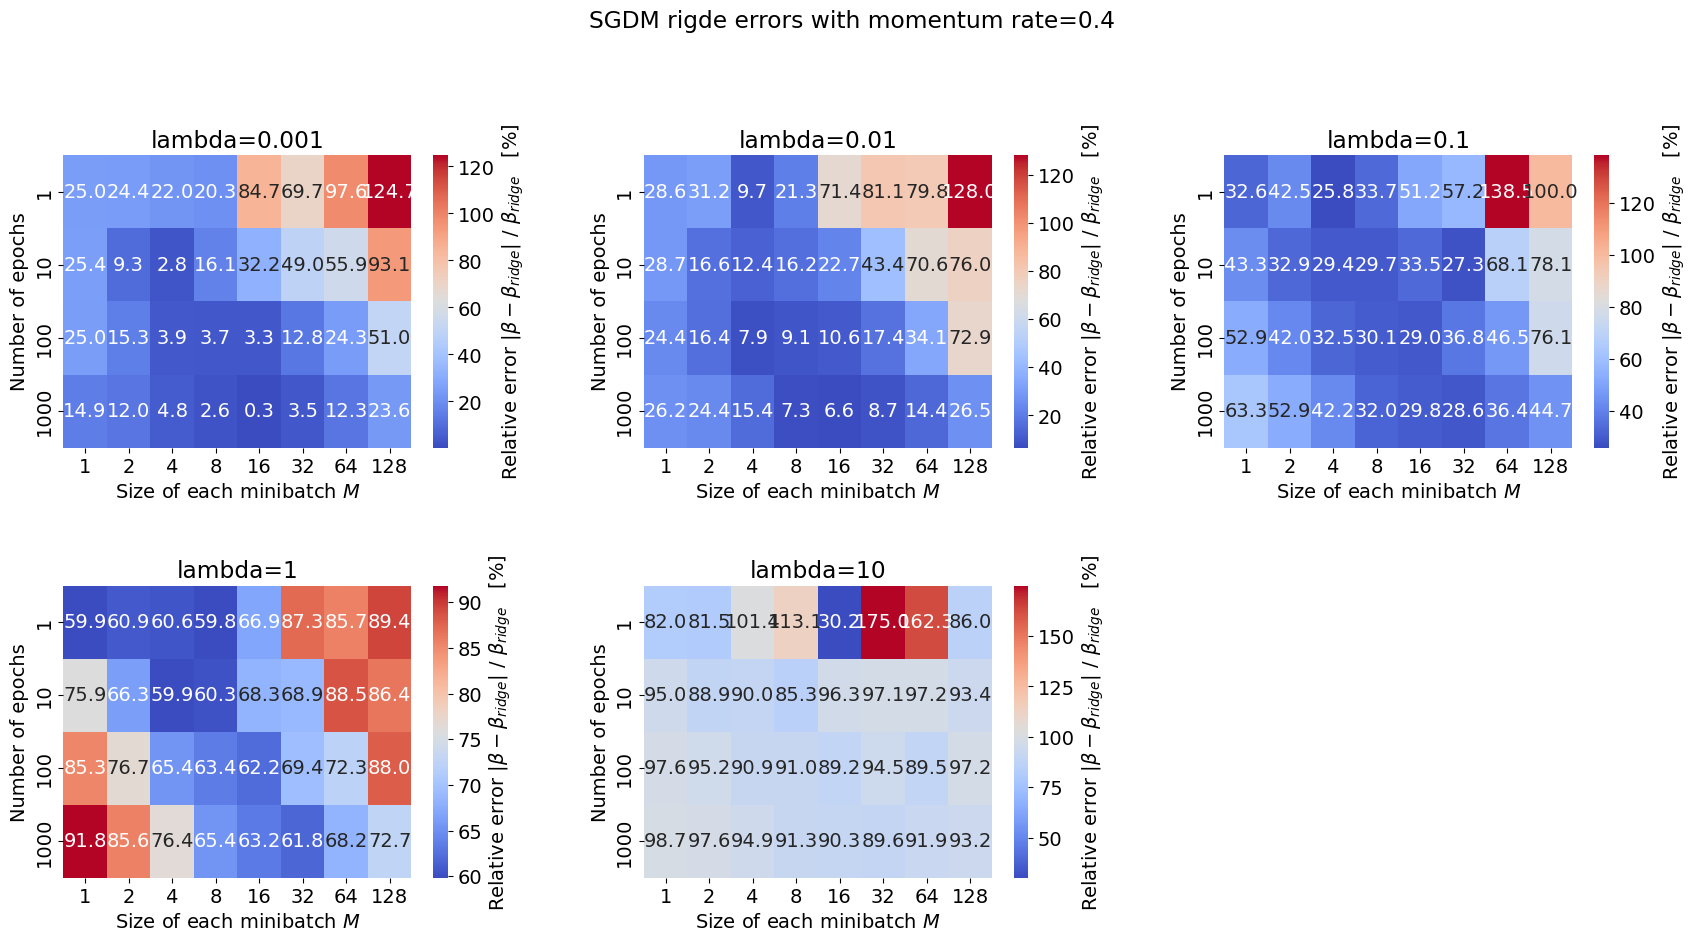

In [88]:
# Ridge parameter
lmdbas = [0.001, 0.01, 0.1, 1, 10]
momentum_rate = 0.4

# Plot error heatmap for each different lambda value
nrows, ncols = 2, 3
fig, axs = plt.subplots(nrows, ncols, figsize=(18, 10))
fig.suptitle(f"SGDM rigde errors with momentum rate={momentum_rate}")

# Remove the final subplot which is not used
axs[-1, -1].remove()

XT_X = X.T @ X
for l, lmbda in enumerate(lmdbas):
    # own Ridge inversion
    I = np.identity(np.shape(XT_X)[0])
    lmbda_I = lmbda * I
    beta_ridge = np.linalg.inv(XT_X + lmbda_I) @ (X.T @ y)  
    
    rel_errors = np.empty((M_vals.size, len(N_epoch_vals)))
    
    # iterate through different epochs values
    for j, N_epoch in enumerate(N_epoch_vals):  
        
        # then iterate through different values of total number of batches m (and corresponding M)
        for i, m in enumerate(m_vals):
            M = M_vals[j]
            beta = rng.standard_normal((2, 1))  # create 2 random beta parameters [b_0, b_1]
            change = 0
            
            # then iterate through all different epoch values
            for epoch in range(N_epoch):  
                
                # now do the GD calculation for each of the minibatches
                for k in range(m):  
                    
                    # Pick a minibatch at random
                    random_index = M * rng.integers(m)
                    xk = X[random_index:random_index + M]
                    yk = y[random_index:random_index + M]
    
                    # Gradient descent on the random batch
                    gradients = 2 / M * xk.T @ ((xk @ beta) - yk) + 2 * lmbda * beta
                    learn_rate = learning_schedule(epoch * m + k)
                    new_change = learn_rate * gradients + momentum_rate * change
                    
                    # Update vals
                    beta -= learn_rate * gradients
                    change = new_change.copy()
            rel_errors[i, j] = np.max(abs(beta - beta_ridge) / beta_ridge)
    
    ### Plot error heatmap
    
    # find row and col indices
    if l < ncols:
        row = 0
        col = l
    else:
        row = 1
        col = l - ncols
    im = sb.heatmap(
            rel_errors.T * 100,
            ax=axs[row, col],
            annot=True,
            fmt=".1f",
            cmap=HEATMAP_CMAP,
            xticklabels=M_vals,
            yticklabels=N_epoch_vals,
            cbar_kws={"label": r"Relative error $|\beta - \beta_{ridge}|\ /\ \beta_{ridge}$   [%]"}  # colorbar label
    )
    axs[row, col].set_title(f"lambda={lmbda}")
    axs[row, col].set_ylabel("Number of epochs")
    axs[row, col].set_xlabel("Size of each minibatch $M$")
    plt.savefig(FIGURES_DIR / "SGD_ridge_momentum.png")
    
fig.tight_layout(pad=3.0)

### 4. Tuning the learning rate with Adagrad for plain GD

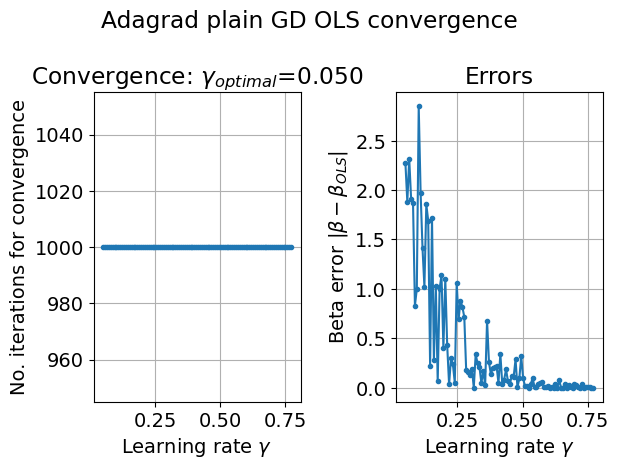

In [58]:
# Parameters
learn_rates = np.linspace(0.05, 2 / np.max(eig_ols), 100, endpoint=False)
delta = 1e-8

no_iters = np.empty(learn_rates.size)  # store the number of iterations needed to converge
errors = np.empty_like(no_iters)  # store the beta errors

error_best = 1e10
beta_best = 0
for i, learn_rate in enumerate(learn_rates):
    # Iterate through and improve beta
    beta = rng.standard_normal((2, 1))  # create 2 random beta parameters [b_0, b_1] to test convergence with
    beta_prev = 0
    r = 0
    iter = 0
    while iter < N_iters and any(abs(beta - beta_prev) > beta_tol):  # convergence test
        beta_prev = beta.copy()

        # Update beta using Adagrad algorithm
        grad = 2 / N * X.T @ (X @ beta - y)
        r += grad*grad
        beta -= grad*learn_rate / (delta+np.sqrt(r))

        iter += 1
    no_iters[i] = iter

    error = np.max(abs(beta - beta_ols))
    if error < error_best:
        error_best = error
        beta_best = beta
    errors[i] = error

fig, axs = plt.subplots(1, 2)
fig.suptitle(f"Adagrad plain GD OLS convergence")

# Plot convergence
axs[0].plot(learn_rates, no_iters, ".-")
axs[0].set_title("Convergence: $\gamma_{optimal}$=" + f"{learn_rates[np.argmin(no_iters)]:.3f}")
axs[0].set_xlabel("Learning rate $\gamma$")
axs[0].set_ylabel("No. iterations for convergence")
axs[0].grid(True)

# Plot error
axs[1].plot(learn_rates, errors, ".-")
axs[1].set_title("Errors")
axs[1].set_xlabel("Learning rate $\gamma$")
axs[1].set_ylabel(r"Beta error $|\beta - \beta_{OLS}|$")
axs[1].grid(True)

plt.tight_layout()

### Ridge:

lmbda=0.0001, beta_ridge=[3.63900031 5.06972089], beta=[3.64066072 5.06579755], max error=0.00392333672975731
lmbda=0.001, beta_ridge=[3.63911818 5.06944248], beta=[3.65543397 5.03073962], max error=0.03870314479277592
lmbda=0.01, beta_ridge=[3.64029512 5.06666165], beta=[3.77866139 4.72535477], max error=0.341306871295874
lmbda=0.1, beta_ridge=[3.65189027 5.03917406], beta=[4.07783639 3.42669666], max error=1.612477501610344
lmbda=1, beta_ridge=[3.75235725 4.79284328], beta=[2.69685964 1.66435397], max error=3.128489300594104
lmbda=10, beta_ridge=[4.07379711 3.60826319], beta=[0.55315696 0.32332048], max error=3.520640157856937


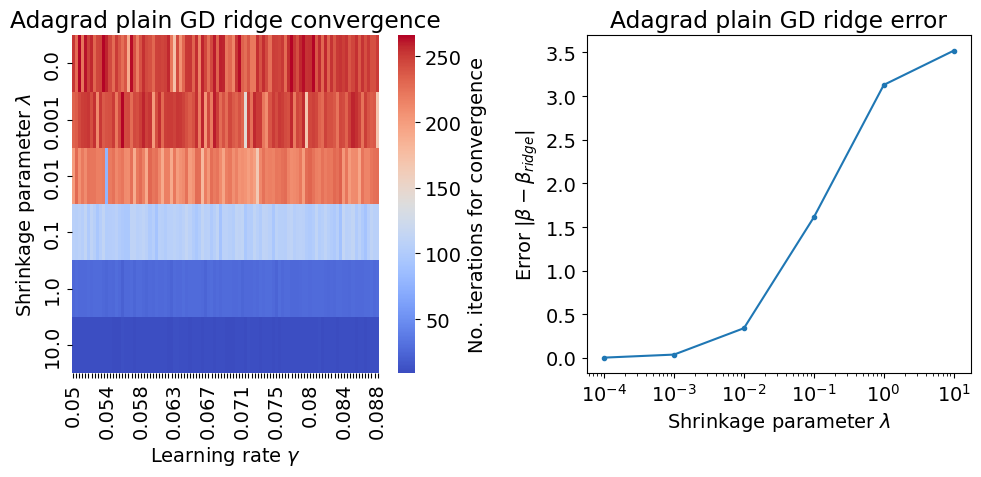

In [56]:
# Parameters
ridge_lambdas = [0.0001, 0.001, 0.01, 0.1, 1, 10]  # lambda vals to plot
delta = 1e-8

no_iters = np.empty((learn_rates.size, len(ridge_lambdas)))  # store the number of iterations needed to converge
errors = np.empty_like(no_iters)  # store the beta errors

# Iterate through each lambda and each learning rate and test convergence
for j, lmbda in enumerate(ridge_lambdas):
    # Calculate max eigenvalue
    XT_X = X.T @ X
    I = np.identity(np.shape(XT_X)[0])
    lmbda_I = lmbda * I

    beta_ridge = np.linalg.inv(XT_X + lmbda_I) @ (X.T @ y)  # own Ridge inversion
    H = 2 / N * XT_X + 2 * lmbda_I  # Hessian matrix
    eig_ridge, iter = np.linalg.eig(H)

    # Create learning rate values to test 
    learn_rates = np.linspace(0.05, 2 / np.max(eig_ridge), 100, endpoint=False)
    for i, learn_rate in enumerate(learn_rates):
        # Iterate through and improve beta
        beta = rng.standard_normal((2, 1))  # create 2 random beta parameters [b_0, b_1] to test convergence with
        beta_prev = 0
        r = 0
        iter = 0
        while iter < N_iters and any(abs(beta - beta_prev) > beta_tol):  # convergence test
            beta_prev = beta.copy()

            # Update beta
            grad = 2 / N * X.T @ (X @ beta - y) + 2 * lmbda * beta
            r += grad*grad
            beta -= learn_rate * grad / (delta * np.sqrt(r))

            # stop if beta is blowing up -> will overflow
            if any(beta > 1e8):
                iter = 1000
                break

            iter += 1
        no_iters[i, j] = iter
        errors[i, j] = np.max(abs(beta - beta_ridge))
    print(f"{lmbda=}, beta_ridge={beta_ridge.ravel()}, beta={beta.ravel()}, max error={errors[0, j]}")

# Heatmap plotting
plt.figure(figsize=(10, 5))

###### Convergence heatmap
# Set xlabel ticks to show a total of 10 values, with 3 decimal places
xticks = np.round(learn_rates, 3)
keptticks = xticks[::int(len(learn_rates) / 10) + 1]
xticks = ['' for _ in xticks]
xticks[::int(len(xticks) / 10) + 1] = keptticks

plt.subplot(1, 2, 1)
ax = sb.heatmap(
        no_iters.T,
        annot=False,
        cmap=HEATMAP_CMAP,
        xticklabels=xticks,
        yticklabels=np.round(ridge_lambdas, 3),
        cbar_kws={"label": "No. iterations for convergence"}  # colorbar label
)
plt.xticks(rotation=90)  # sideways xticks
plt.title("Adagrad plain GD ridge convergence")
plt.xlabel("Learning rate $\gamma$")
plt.ylabel("Shrinkage parameter $\lambda$")
######


###### Error plot
plt.subplot(1, 2, 2)
plt.plot(ridge_lambdas, errors[0, :], ".-")  # the errors are almost the same for each learning rate value
plt.title("Adagrad plain GD ridge error")
plt.ylabel(r"Error $|\beta-\beta_{ridge}|$")
plt.xlabel("Shrinkage parameter $\lambda$")
plt.xscale("log")
###### 
plt.savefig(FIGURES_DIR / "adagrad_GD_Ridge.png")
plt.tight_layout()

In [61]:
def SGD_adagrad(npoints, x, y, order, lmbda, linreg0_ridge1, n_epochs, minibatch_size, delta, eta):

    X = design_matrix_1d(x, order)
    
    np.random.seed(7)
    beta = np.array([4, 3, 2]) + np.random.normal(0, 0.5, size=order+1)

    beta = np.expand_dims(beta, axis=1)
    
    M = minibatch_size 
    m = int(npoints/M) 
    for epoch in range(n_epochs):
        #initialize empty matrix for gradient RMS
        Giter = np.zeros(shape=(order+1,order+1))
        for i in range(m):
            random_index = M*np.random.randint(m)
            xi = X[random_index:random_index+M]
            yi = y[random_index:random_index+M]

            if linreg0_ridge1 == 0:
                gradient = (2.0 / npoints) * xi.T @ (xi @ beta-yi)
            elif linreg0_ridge1 == 1:
                gradient = (2.0 / npoints) * xi.T @ (xi @ (beta)-yi) + 2 * lmbda * beta
            
            # calculate gradient RMS
            Giter += gradient @ gradient.T

            Ginverse = np.c_[eta/(delta+np.sqrt(np.diagonal(Giter)))]
            update = np.multiply(Ginverse,gradient)

            beta -= update

    ypred = X @ beta

    return ypred

def SGD_RMSprop(npoints, x, y, order, lmbda, linreg0_ridge1, n_epochs, minibatch_size, delta, rho, eta):

    X = design_matrix_1d(x, order)
    
    np.random.seed(7)
    beta = np.array([4, 3, 2]) + np.random.normal(0, 0.5, size=order+1)
    beta = np.expand_dims(beta, axis=1)
    
    M = minibatch_size 
    m = int(npoints/M) 
    
    for epoch in range(n_epochs):
        Giter = np.zeros(shape=(order+1,order+1))
        for i in range(m):
            random_index = M*np.random.randint(m)
            xi = X[random_index:random_index+M]
            yi = y[random_index:random_index+M]

            if linreg0_ridge1 == 0:
                gradient = (2.0 / npoints) * xi.T @ (xi @ beta-yi)
            elif linreg0_ridge1 == 1:
                gradient = (2.0 / npoints) * xi.T @ (xi @ (beta)-yi) + 2 * lmbda * beta
            
            Giter_o = np.copy(Giter)
            Previous = Giter_o
            Giter += gradient @ gradient.T
        
            # calculate moving average of the gradients
            Gnew = (rho * Previous + (1-rho) * Giter)

            Ginverse = np.c_[eta / (delta + np.sqrt(np.diagonal(Gnew)))]
            update = np.multiply(Ginverse, gradient)

            beta -= update

    ypred = X @ beta

    return ypred


def SGD_adam(npoints, x, y, order, lmbda, linreg0_ridge1, n_epochs, minibatch_size, beta1, beta2, delta, eta):

    X = design_matrix_1d(x, order)

    Id = npoints * lmbda * np.eye((X.T @ X).shape[0])

    np.random.seed(7)
    beta = np.array([4, 3, 2]) + np.random.normal(0, 0.5, size=order+1)
    beta = np.expand_dims(beta, axis=1)

    M = minibatch_size 
    m = int(npoints/M) 
    
    moment1 = np.zeros(order+1)
    moment1 = np.expand_dims(moment1, axis=1)
    moment2 = np.zeros(order+1)
    moment2 = np.expand_dims(moment2, axis=1)
    
    for epoch in range(n_epochs):

        for i in range(m):
            random_index = M*np.random.randint(m)
            xi = X[random_index:random_index+M]
            yi = y[random_index:random_index+M]


            if linreg0_ridge1 == 0:
                gradient = (2.0 / npoints) * xi.T @ (xi @ beta-yi)
            elif linreg0_ridge1 == 1:
                gradient = (2.0 / npoints) * xi.T @ (xi @ (beta)-yi) + 2 * lmbda * beta

            # calculating moving average of the gradient and gradient squared with momentum
            moment1 = beta1 * moment1 + (1.0 - beta1) * gradient
            moment2 = beta2 * moment2 + (1.0 - beta2) * gradient**2

            mhat = moment1 / (1.0 - beta1**(i+1))
            vhat = moment2  / (1.0 - beta2**(i+1))

            beta -= eta * mhat / (np.sqrt(vhat) + delta)

    ypred = X @ beta

    return ypred

In [62]:
SGD_adagrad_mse = []
SGD_RMSprop_mse = []
SGD_adam_mse = []
N = 128
eta = 0.01
linreg0_ridge1 = 0
lmbda = 0.01
#lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
order = 2
for n_epochs in range(1, 101):
    y_pred_adagrad = SGD_adagrad(N, x, y, order, lmbda, linreg0_ridge1, n_epochs, 
                 minibatch_size=5, delta=1e-8, eta=eta)

    
    y_pred_RMSprop = SGD_RMSprop(N, x, y, order, lmbda, linreg0_ridge1, n_epochs, 
                 minibatch_size=5, rho=0.9, delta=1e-8, eta=eta)

    y_pred_adam = SGD_adam(N, x, y, order, lmbda, linreg0_ridge1, n_epochs, 
                minibatch_size=5, beta1=0.7, beta2=0.8, delta=1e-8, eta=eta)

    SGD_adagrad_mse.append(MSE(y_pred_adagrad, y))
    SGD_RMSprop_mse.append(MSE(y_pred_RMSprop, y))
    SGD_adam_mse.append(MSE(y_pred_adam, y))

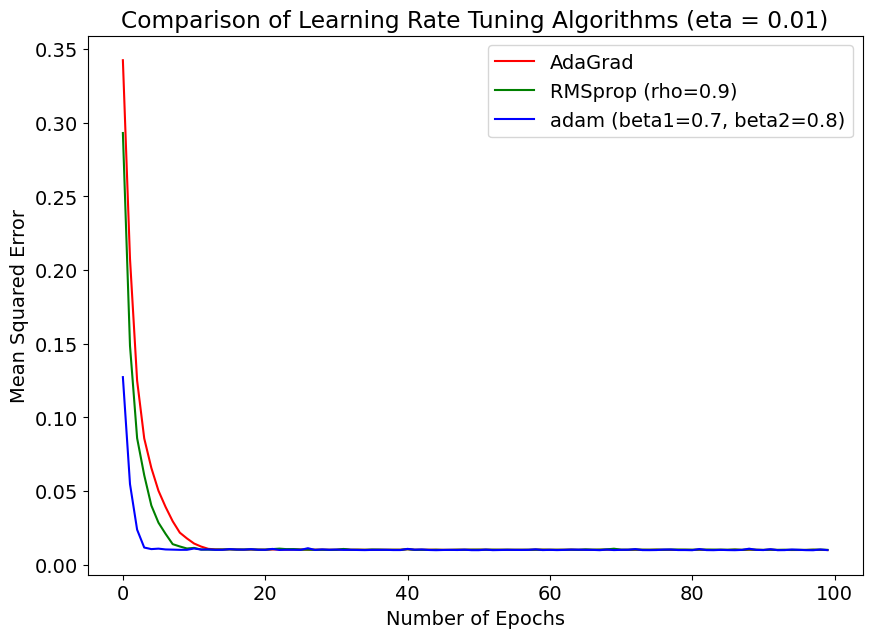

In [63]:
plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(SGD_adagrad_mse, 'r', label='AdaGrad')
ax.plot(SGD_RMSprop_mse, 'g', label='RMSprop (rho=0.9)')
ax.plot(SGD_adam_mse, 'b', label='adam (beta1=0.7, beta2=0.8)')
#ax.set_ylim(-0.01,0.25)
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Number of Epochs')
ax.legend()

ax.set_title('Comparison of Learning Rate Tuning Algorithms (eta = 0.01)')
plt.savefig(FIGURES_DIR / "Adagrad_RMS_adam.png")

Discussion:
OLS: The OLS model shows that it can fit the data well with an appropriate learning rate (0.1). However, it starts with a high error at lower learning rates, indicating sensitivity to learning rate settings.
Ridge Regression: The Ridge model does not perform as well, especially at higher learning rates. This suggests that the regularization term may be too strong given the noise in the data, leading to underfitting.
SGD: The Stochastic Gradient Descent (SGD) models perform significantly better across learning rates, especially at 0.01, indicating that this method effectively optimizes the loss function.

### Part d): Classification  analysis using neural networks

With a well-written code it should now be easy to change the
activation function for the output layer.

Here we will change the cost function for our neural network code
developed in parts b) and c) in order to perform a classification analysis. 

We will here study the Wisconsin Breast Cancer  data set. This is a typical binary classification problem with just one single output, either True or Fale, $0$ or $1$ etc.
You find more information about this at the [Scikit-Learn
site](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html) or at the [University of California
at Irvine](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)). 

To measure the performance of our classification problem we use the
so-called *accuracy* score.  The accuracy is as you would expect just
the number of correctly guessed targets $t_i$ divided by the total
number of targets, that is

$$
\text{Accuracy} = \frac{\sum_{i=1}^n I(t_i = y_i)}{n} ,
$$

where $I$ is the indicator function, $1$ if $t_i = y_i$ and $0$
otherwise if we have a binary classification problem. Here $t_i$
represents the target and $y_i$ the outputs of your FFNN code and $n$ is simply the number of targets $t_i$.

Discuss your results and give a critical analysis of the various parameters, including hyper-parameters like the learning rates and the regularization parameter $\lambda$ (as you did in Ridge Regression), various activation functions, number of hidden layers and nodes and activation functions.  

As stated in the introduction, it can also be useful to study other
datasets. 

Again, we strongly recommend that you compare your own neural Network
code for classification and pertinent results against a similar code using **Scikit-Learn**  or **tensorflow/keras** or **pytorch**.

Epoch 0, Loss: 0.7234, Accuracy: 0.4675
Epoch 100, Loss: 0.3728, Accuracy: 0.9051
Epoch 200, Loss: 0.2298, Accuracy: 0.9402
Epoch 300, Loss: 0.1744, Accuracy: 0.9525
Epoch 400, Loss: 0.1433, Accuracy: 0.9684
Epoch 500, Loss: 0.1232, Accuracy: 0.9736
Epoch 600, Loss: 0.1090, Accuracy: 0.9754
Epoch 700, Loss: 0.0986, Accuracy: 0.9789
Epoch 800, Loss: 0.0907, Accuracy: 0.9789
Epoch 900, Loss: 0.0844, Accuracy: 0.9824
Epoch 1000, Loss: 0.0794, Accuracy: 0.9859
Epoch 1100, Loss: 0.0754, Accuracy: 0.9877
Epoch 1200, Loss: 0.0720, Accuracy: 0.9877
Epoch 1300, Loss: 0.0692, Accuracy: 0.9877
Epoch 1400, Loss: 0.0668, Accuracy: 0.9877
Epoch 1500, Loss: 0.0647, Accuracy: 0.9877
Epoch 1600, Loss: 0.0629, Accuracy: 0.9895
Epoch 1700, Loss: 0.0612, Accuracy: 0.9895
Epoch 1800, Loss: 0.0596, Accuracy: 0.9877
Epoch 1900, Loss: 0.0582, Accuracy: 0.9877
Epoch 1999, Loss: 0.0569, Accuracy: 0.9877
Final Accuracy on the dataset: 0.9877


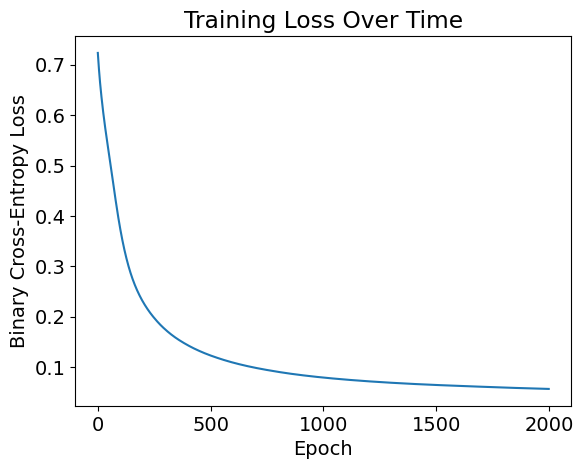

In [69]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from functions import*


# Data Preparation
data = load_breast_cancer()
inputs = data.data
targets = data.target.reshape(-1, 1)  # Ensure targets are column vectors

# Standardize the inputs
scaler = StandardScaler()
inputs = scaler.fit_transform(inputs)

# Network Architecture
input_size = inputs.shape[1]
output_size = 1
layer_sizes = [input_size, 16, 8, output_size]
activations = ['relu', 'relu', 'sigmoid']

# Create and Train the Neural Network
nn = NeuralNetwork(layer_sizes, activations)
epochs = 2000
learning_rate = 0.01
losses = nn.train(inputs, targets, epochs, learning_rate)

# Evaluate the Network
predictions = nn.forward(inputs)
accuracy = compute_accuracy(predictions, targets)
print(f'Final Accuracy on the dataset: {accuracy:.4f}')

# Plot Training Loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.title('Training Loss Over Time')
plt.savefig(FIGURES_DIR / "logistic_cancer_test.png")
plt.show()


In [68]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=42)

# Create and train the MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(16, 8), activation='relu', solver='adam', max_iter=2000, random_state=42)
mlp.fit(X_train, y_train.ravel())  # Flatten the targets for fitting

# Evaluate the model
accuracy_sklearn = mlp.score(X_test, y_test)
print(f'Accuracy using Scikit-Learn MLPClassifier: {accuracy_sklearn:.4f}')

Accuracy using Scikit-Learn MLPClassifier: 0.9737


### Part e): Write your Logistic Regression code, final step

Finally, we want to compare the FFNN code we have developed with
Logistic regression, that is we wish to compare our neural network
classification results with the results we can obtain with another
method.

Define your cost function and the design matrix before you start writing your code.
Write thereafter a Logistic regression code using your SGD algorithm. You can also use standard gradient descent in this case, with a learning rate as hyper-parameter.
Study the results as functions of the chosen learning rates.
Add also an $l_2$ regularization parameter $\lambda$. Compare your results with those from your FFNN code as well as those obtained using **Scikit-Learn**'s logistic regression functionality.

The weblink  here <https://medium.com/ai-in-plain-english/comparison-between-logistic-regression-and-neural-networks-in-classifying-digits-dc5e85cd93c3>compares logistic regression and FFNN using the so-called MNIST data set. You may find several useful hints and ideas from this article.

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import io
import pandas as pd
from jax import grad
import jax.numpy as jnp
import numpy.random as npr
from sklearn.metrics import accuracy_score
import seaborn as sns
from functions import*

In [71]:
breast_cancer = load_breast_cancer()

X, y = breast_cancer.data, breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler() 
scaler.fit(X_train) 
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [72]:
etas = np.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])
lmbdas = np.array([0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1])

log_reg_grid = np.zeros((len(etas), len(lmbdas)))
                        
for eta,i in zip(etas, range(len(etas))):
    for lmbd,j in zip(lmbdas, range(len(lmbdas))):
        test_accuracies = log_reg(X_train_scaled, y_train, X_test_scaled, y_test, 
                                n_epochs=100, minibatch_size=10, eta=eta, lmbd=lmbd)
                        
        final_acc = test_accuracies[-1]
        log_reg_grid[i,j] = final_acc
    print(i)

0
1
2
3


C:\Users\user\AppData\Local\Temp\ipykernel_1552\2438264563.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


4


C:\Users\user\AppData\Local\Temp\ipykernel_1552\2438264563.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Users\user\AppData\Local\Temp\ipykernel_1552\2438264563.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


5


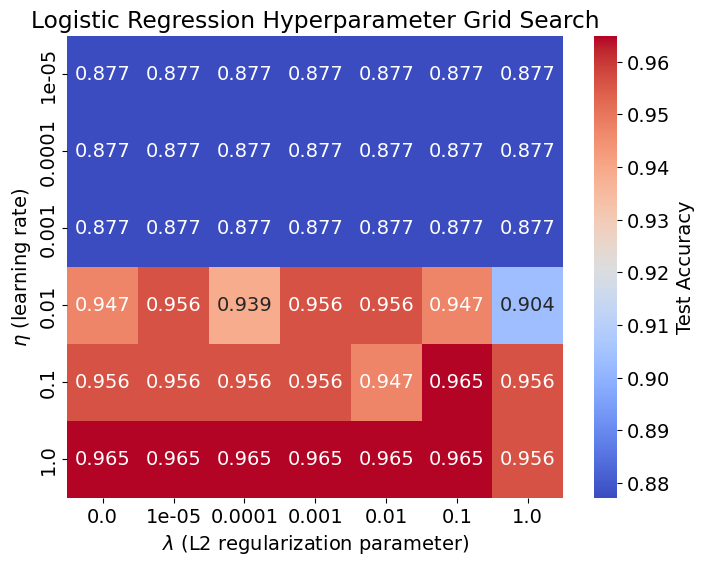

In [81]:
plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(figsize=(8,6))

sns.heatmap(log_reg_grid, annot=True, cmap='coolwarm', fmt='.3g', cbar_kws={'label': 'Test Accuracy'})
ax.set_xticklabels(lmbdas.round(5))
ax.set_yticklabels(etas.round(5))
ax.set_ylabel("$\\eta$ (learning rate)")
ax.set_xlabel("$\\lambda$ (L2 regularization parameter)")
ax.set_title('Logistic Regression Hyperparameter Grid Search')
plt.savefig(FIGURES_DIR / "logistic_Regression.png")

#fig.savefig('log_reg_grid_search.jpg', dpi=1000, bbox_inches='tight')

## Use best model params (eta = 1, lmbd = 0) and worst that worked (eta = 0.01, lmbd=1) to compare.

In [74]:
test_acc_eta1_lmbd0 = log_reg(X_train_scaled, y_train, X_test_scaled, y_test, 
                              n_epochs=100, minibatch_size=10, eta=1, lmbd=0)

test_acc_eta001_lmbd1 = log_reg(X_train_scaled, y_train, X_test_scaled, y_test, 
                              n_epochs=100, minibatch_size=10, eta=0.01, lmbd=1)

test_acc_eta1_lmbd0_unscaled = log_reg(X_train, y_train, X_test, y_test, 
                              n_epochs=100, minibatch_size=10, eta=1, lmbd=0)

test_acc_eta001_lmbd1_unscaled = log_reg(X_train, y_train, X_test, y_test, 
                              n_epochs=100, minibatch_size=10, eta=0.01, lmbd=1)

C:\Users\user\AppData\Local\Temp\ipykernel_1552\2438264563.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Users\user\AppData\Local\Temp\ipykernel_1552\2438264563.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


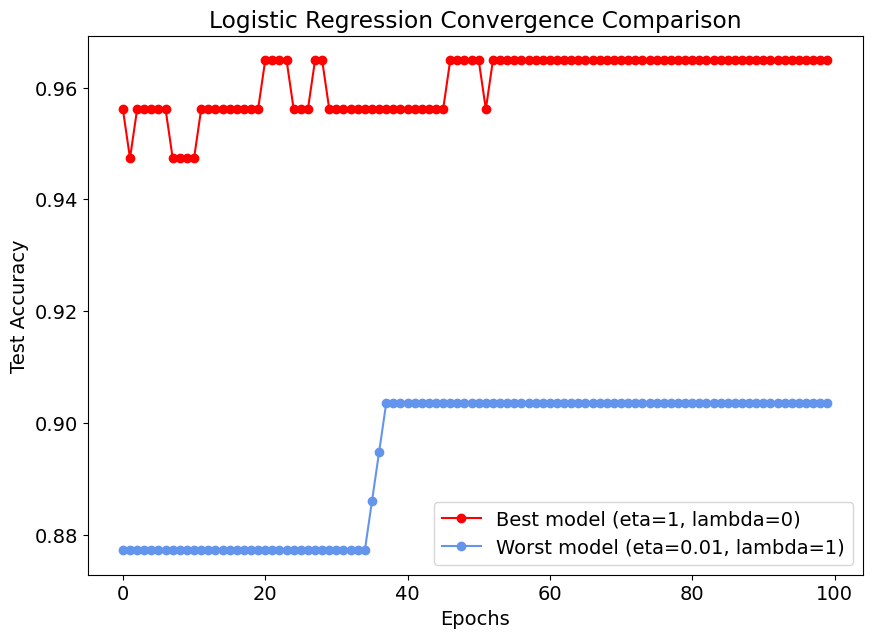

In [78]:

#print(test_acc_eta1_lmbd0)

plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(test_acc_eta1_lmbd0, '-o', color='red', label='Best model (eta=1, lambda=0)')
ax.plot(test_acc_eta001_lmbd1, '-o', color='cornflowerblue', label='Worst model (eta=0.01, lambda=1)')

ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Test Accuracy')
ax.set_title('Logistic Regression Convergence Comparison')
plt.savefig(FIGURES_DIR / "log_reg_best_vs_worst.png")
#fig.savefig('log_reg_best_vs_worst.jpg', dpi=1000, bbox_inches='tight')

### test the impact of data scaling

In [79]:
test_acc_eta1_lmbd0_unscaled = log_reg(X_train, y_train, X_test, y_test, 
                              n_epochs=100, minibatch_size=10, eta=1, lmbd=0)

test_acc_eta001_lmbd1_unscaled = log_reg(X_train, y_train, X_test, y_test, 
                              n_epochs=100, minibatch_size=10, eta=0.01, lmbd=1)

C:\Users\user\AppData\Local\Temp\ipykernel_1552\2438264563.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Users\user\AppData\Local\Temp\ipykernel_1552\2438264563.py:9: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


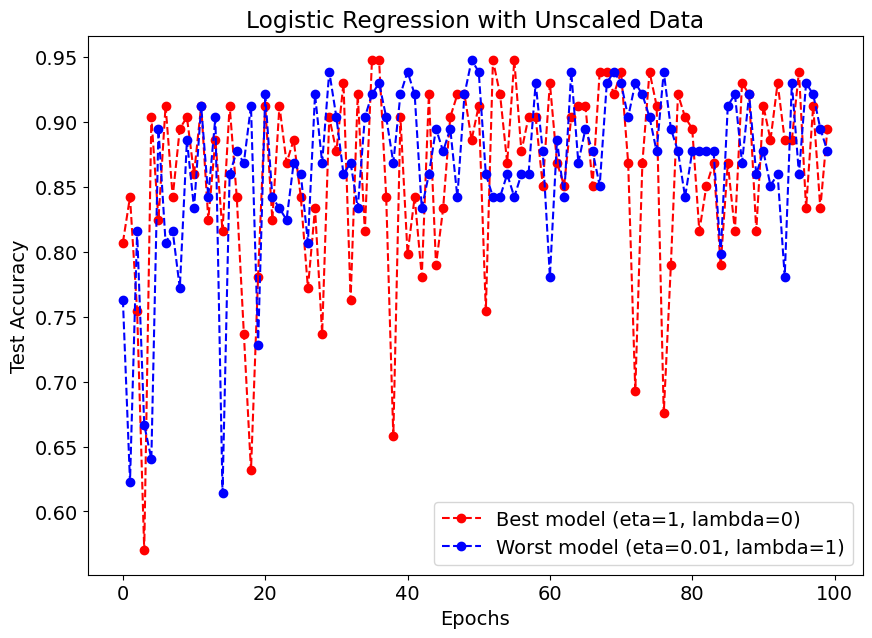

In [80]:
fig,ax = plt.subplots(figsize=(10,7))

ax.plot(test_acc_eta1_lmbd0_unscaled, '--o', color='red', label='Best model (eta=1, lambda=0)')
ax.plot(test_acc_eta001_lmbd1_unscaled, '--o', color='blue', label='Worst model (eta=0.01, lambda=1)')
ax.legend()
ax.set_title('Logistic Regression with Unscaled Data')
#ax.set_ylim(0.39, 0.965)
ax.set_xlabel('Epochs')
ax.set_ylabel('Test Accuracy')
plt.savefig(FIGURES_DIR / "log_reg_scaled_vs_unscaled.png")
#fig.savefig('log_reg_scaled_vs_unscaled.jpg', dpi=1000, bbox_inches='tight')

In [13]:
from sklearn.linear_model import LogisticRegression

# Best Model (C = 1 / lambda, where lambda = 0 → C = a large value, no regularization)
clf_best = LogisticRegression(C=1e6, max_iter=100, solver='lbfgs', random_state=0)  # Large C approximates lambda = 0
clf_best.fit(X_train_scaled, y_train)
best_acc_sklearn = clf_best.score(X_test_scaled, y_test)

# Worst Model (C = 1 / lambda, where lambda = 1 → C = 1)
clf_worst = LogisticRegression(C=1, max_iter=100, solver='lbfgs', random_state=0)
clf_worst.fit(X_train_scaled, y_train)
worst_acc_sklearn = clf_worst.score(X_test_scaled, y_test)

print(f"Scikit-Learn Logistic Regression (Best Model) Test Accuracy: {best_acc_sklearn:.4f}")
print(f"Scikit-Learn Logistic Regression (Worst Model) Test Accuracy: {worst_acc_sklearn:.4f}")


Scikit-Learn Logistic Regression (Best Model) Test Accuracy: 0.9561
Scikit-Learn Logistic Regression (Worst Model) Test Accuracy: 0.9649
